## Import data_utils

In [1]:
from climsim_utils.data_utils import *

2023-08-21 21:52:44.783708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 21:52:45.719702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Instantiate class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

## Load training and validation data

In [3]:
# Change this path to your own
gen_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/'

train_input_path = gen_path + 'train_input.npy'
train_target_path = gen_path + 'train_target.npy'
val_input_path = gen_path + 'val_input.npy'
val_target_path = gen_path + 'val_target.npy'

data.input_train = data.load_npy_file(train_input_path)
data.target_train = data.load_npy_file(train_target_path)
data.input_val = data.load_npy_file(val_input_path)
data.target_val = data.load_npy_file(val_target_path)

## Train constant prediction model

In [12]:
const_model = data.target_train.mean(axis = 0)

## Train multiple linear regression model

#### adding bias unit

In [5]:
X = data.input_train
bias_vector = np.ones((X.shape[0], 1))
X = np.concatenate((X, bias_vector), axis=1)

#### create model

In [6]:
mlr_weights = np.linalg.inv(X.transpose()@X)@X.transpose()@data.target_train

## Load scoring data and set pressure grid

In [7]:
scoring_input_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy"
scoring_target_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy"

# path to target input
data.input_scoring = np.load(scoring_input_path)

# path to target output
data.target_scoring = np.load(scoring_target_path)

# set pressure weights
data.set_pressure_grid(input_arr = data.input_scoring)

## Load predictions

In [13]:
# constant prediction
const_pred = np.repeat(const_model[np.newaxis, :], data.target_scoring.shape[0], axis = 0)
const_pred.shape

(1681920, 128)

In [19]:
# multiple linear regression

# add bias vector
X_scoring = data.input_scoring
bias_vector_scoring = np.ones((X_scoring.shape[0], 1))
X_scoring = np.concatenate((X_scoring, bias_vector_scoring), axis=1)
mlr_pred = X_scoring@mlr_weights
mlr_pred.shape

(1681920, 128)

## Weight outputs

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [20]:
data.model_names = ['const', 'mlr']
preds = [const_pred, mlr_pred]
data.preds_scoring = dict(zip(data.model_names, preds))

data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

data.metrics_names = ['MAE', 'RMSE', 'R2', 'bias']
data.create_metrics_df(data_split = 'scoring')

/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:656: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:656: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:656: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/neurips_proj/ClimSim/climsim_utils/data_utils.py:656: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time


## Create plots

In [21]:
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

In [23]:
dict_var = data.metrics_var_scoring
plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_var[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

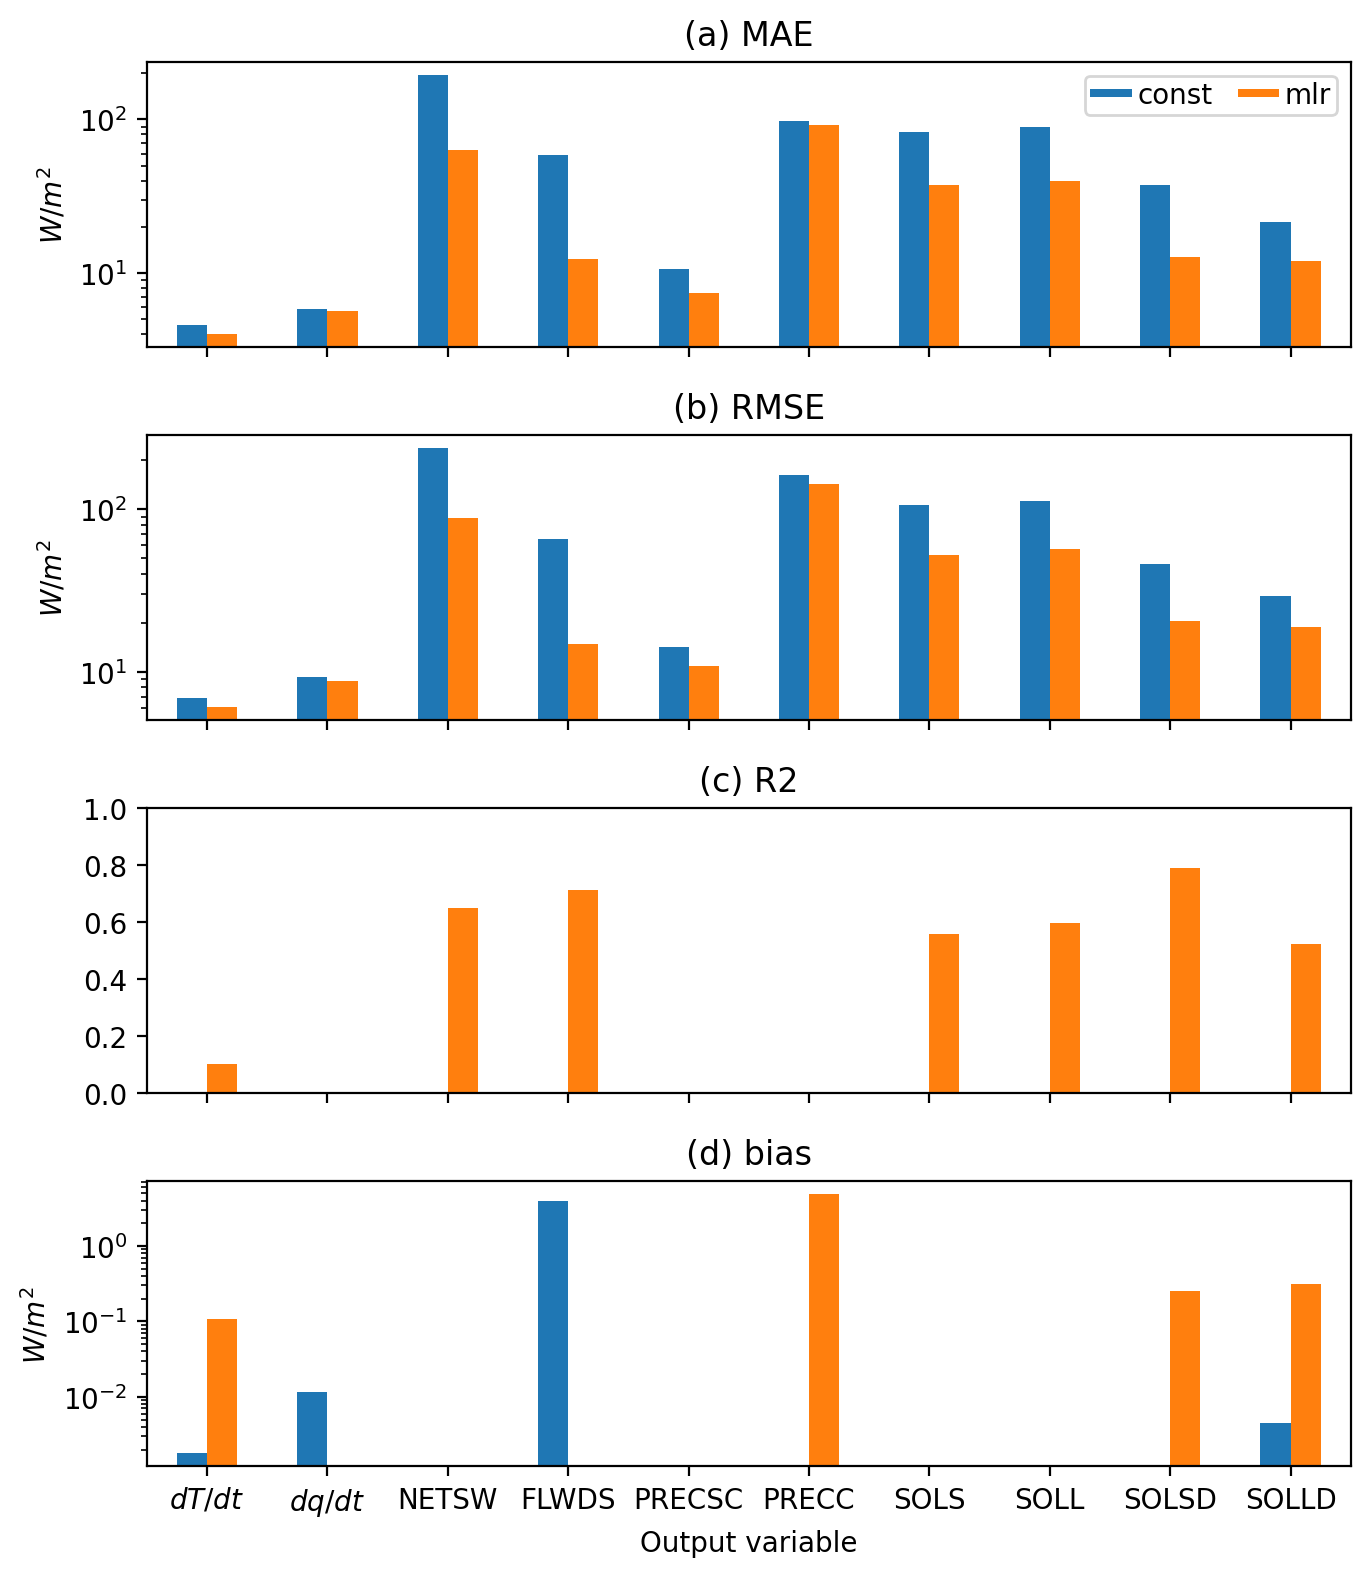

In [24]:
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
        axes[i].set_yscale('log')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()